# Notebook to evalute each Model in more detail

In [1]:
# Imports
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import json
import statistics
from typing import Dict


from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

# to enable local imports
module_path = os.path.abspath('../code')
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

    
from pathlib import Path
try:
    try:
        json_path = (Path(os.getenv('LOCALAPPDATA'))/'Dropbox'/'info.json').resolve()
    except FileNotFoundError:
        json_path = (Path(os.getenv('APPDATA'))/'Dropbox'/'info.json').resolve()

    with open(str(json_path)) as f:
        j = json.load(f)

    personal_dbox_path = Path(j['personal']['path'])
    # Save the images directly into the dropbox where the overleaf document is stored
    IMAGES_PATH = os.path.join(str(personal_dbox_path), 'Apps', 'Overleaf', 'Masterthesis_Paper', 'images')

except Exception as e:
    IMAGES_PATH = "../images"
    print(e)
    
print("Saving images to: {}".format(IMAGES_PATH))
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, bbox_inches='tight')

from machine_learning_load_data import loadOnlineEEGdata
from utils import loadTargetLabelsTxt

D:\Masterthesis\thesis_eeg\code
Saving images to: D:\Dropbox\Apps\Overleaf\Masterthesis_Paper\images


In [2]:
# Load some online EEG Data

##################
# online eeg data
##################
eegData, freqData, entropyData = loadOnlineEEGdata(dirPath='../../EEG_Data/eeg_data_online', splitData=True)

X_train_eeg, y_train_eeg, X_test_eeg, y_test_eeg = eegData
X_train_freq, y_train_freq, X_test_freq, y_test_freq = freqData
X_train_entropy, y_train_entropy, X_test_entropy, y_test_entropy = entropyData

# reshape
X_train_freq = X_train_freq.reshape(X_train_freq.shape[0], X_train_freq.shape[2])
X_test_freq = X_test_freq.reshape(X_test_freq.shape[0], X_test_freq.shape[2])

X_train_entropy = X_train_entropy.reshape(X_train_entropy.shape[0], X_train_entropy.shape[2])
X_test_entropy = X_test_entropy.reshape(X_test_entropy.shape[0], X_test_entropy.shape[2])

targetLabelsDict = loadTargetLabelsTxt(filePath='../../EEG_Data/eeg_data_online/target_labels.txt')
targetNames = ['Fatigue ({})'.format(targetLabelsDict['FATIGUE']),
               'Normal ({})'.format(targetLabelsDict['NORMAL'])]


##################
# experiment data
##################
eegData_exp, freqData_exp, entropyData_exp = loadOnlineEEGdata(dirPath='../../EEG_Data/muse_data', splitData=True)

X_train_eeg_exp, y_train_eeg_exp, X_test_eeg_exp, y_test_eeg_exp = eegData_exp
X_train_freq_exp, y_train_freq_exp, X_test_freq_exp, y_test_freq_exp = freqData_exp
X_train_entropy_exp, y_train_entropy_exp, X_test_entropy_exp, y_test_entropy_exp = entropyData_exp

# reshape
X_train_freq_exp = X_train_freq_exp.reshape(X_train_freq_exp.shape[0], X_train_freq_exp.shape[2])
X_test_freq_exp = X_test_freq_exp.reshape(X_test_freq_exp.shape[0], X_test_freq_exp.shape[2])

X_train_entropy_exp = X_train_entropy_exp.reshape(X_train_entropy_exp.shape[0], X_train_entropy_exp.shape[2])
X_test_entropy_exp = X_test_entropy_exp.reshape(X_test_entropy_exp.shape[0], X_test_entropy_exp.shape[2])

targetLabelsDict_exp = loadTargetLabelsTxt(filePath='../../EEG_Data/muse_data/target_labels.txt')
targetNames_exp = ['AWAKE ({})'.format(targetLabelsDict_exp['AWAKE']),
               'FATIGUE ({})'.format(targetLabelsDict_exp['FATIGUE'])]

Loading Online EEG Data from ../../EEG_Data/eeg_data_online ...
EEG Data Shape:
(5024, 512, 40) (5024,) (2154, 512, 40) (2154,)
Freq Data Shape:
(1008, 1, 1200) (1008,) (432, 1, 1200) (432,)
Entropy Data Shape:
(5024, 1, 200) (5024,) (2154, 1, 200) (2154,)
Loading Online EEG Data from ../../EEG_Data/muse_data ...
EEG Data Shape:
(5393, 512, 4) (5393,) (2312, 512, 4) (2312,)
Freq Data Shape:
(1084, 1, 120) (1084,) (465, 1, 120) (465,)
Entropy Data Shape:
(5393, 1, 20) (5393,) (2312, 1, 20) (2312,)


In [24]:
targetNames

['Fatigue (1)', 'Normal (0)']

['AWAKE (0)', 'FATIGUE (1)']

## Functions to evalute a Model (maybe move into a .py file)

In [55]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve


from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
f1_scorer = make_scorer(f1_score) 

from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.title("ROC Curve")
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)   

def plot_precision_vs_recall(precisions, recalls):
    plt.title("Precision versus recall")
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    
    plt.title("Precision versus recall - Threshold Plot")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)      


# Create a model
def evaluateModel(model, X_train, y_train, X_test=None, y_test=None, kfoldTimes=8, n_jobs=-1, scoring_acc=False, experiment_data=False,
                  confusion_matrix_title="Confusion Matrix"):
    '''
    Function to evalute a model. It evalutes the following metrics:
        - Cross Validation: prints each fold; Calculates thea mean and std. dev. and plots/save it.
        - Calculate recall, precision and F1 score and plots/save it.
        - Calcualte the confusion matrix with the test data and plots/saves it.
    
    @params:
    skLearn 'model': A model from the sklearn package, e.g. from ensemble or a svm
    'X_train': 
    'y_train':
    'X_test':
    'y_test':
    int 'kFoldTimes': Number of folds during the cross validation
    int 'n_jobs': If -1 then we use all cores. If not set the numbers of cores. None -> 1 Core
    Boolean 'scoring_acc': If true we use the accuarcy measurement for the cross validation. If false we use the F1 Scorer.
    Boolean 'experiemnt_data': Experiment_data is only used because the targets are a little different
    String 'confusion_matrix_title': A title for the confusion matrix. Will be saved with this name as well. 
    '''
    print("Model: {}".format(model))
    
    # generate cross val score
    print("Calculating cross val scores...")
    
    if scoring_acc:
        accuaries = cross_val_score(model, X_train, y_train, cv=kfoldTimes, scoring='accuracy', n_jobs=n_jobs)
    else:
        accuaries = cross_val_score(model, X_train, y_train, cv=kfoldTimes, scoring=f1_scorer, n_jobs=n_jobs)
    print("Cross val scores (Accuracies):")
     
    for i in range(0, len(accuaries)):
        print(" Fold {fold}: {acc}".format(fold=i+1, acc=accuaries[i]))
    
    
    print("------------------")
    
    mean_acc = statistics.mean(accuaries)
    std_dev_acc = statistics.stdev(accuaries)
    print("Mean: {}".format(mean_acc))
    print("Std. Dev.: {}".format(std_dev_acc))
          
    
    # make predictions with the model
    print("\nCaclulating cross val predictions...")
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=kfoldTimes, n_jobs=n_jobs)


    my_confusionMatrix = confusion_matrix(y_train, y_train_pred)
    print("""\nConfusion Matrix\n------------------------
    True Negative:   {tn} - False Positive: {fp}
    False Negatives: {fn} - True positive:  {tp}""".format(tn=my_confusionMatrix[0][0],
                                                           fp=my_confusionMatrix[0][1],
                                                           fn=my_confusionMatrix[1][0],
                                                           tp=my_confusionMatrix[1][1]))
    '''
    print("----------------------")
    
    precision = precision_score(y_train, y_train_pred)
    recall = recall_score(y_train, y_train_pred)
    f1_score_val = f1_score(y_train, y_train_pred)
    print("Precision: {} ".format(precision))
    print("Recall:    {}".format(recall))
    print("F1 Score:  {}".format(f1_score_val))
    
    # We need to fit the model, to be able to create the confusion matrix
    model.fit(X_train, y_train)
    
    if experiment_data:
        labels = targetNames_exp
    else:
        labels = targetNames
    
    disp = plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=labels,
                                 normalize=None, # None => no normalization
                                 cmap=plt.cm.Blues)
    disp.ax_.set_title(confusion_matrix_title)
    
    # save confusion matrix
    save_fig(confusion_matrix_title)
    
    
    
    """
    # Calculate and plot the precion-recall tradeoff
    model.fit(X_train, y_train)
    y_score = model.decision_function(X_train)
    average_precision = average_precision_score(y_train, y_score)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    
    disp = plot_precision_recall_curve(model, X_train, y_train)
    disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    
    
    # Calculate and plot precision vs. recall - threshold plot
    y_scores_dec_func = cross_val_predict(model, X_train, y_train, cv=kfoldTimes, method="decision_function", n_jobs=n_jobs)
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_dec_func)
    
    plt.figure(figsize=(8, 4))
    plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
    
    # Plot precision vs. recall directly against each other
    plt.figure(figsize=(8, 6))
    plot_precision_vs_recall(precisions, recalls)
    
    
    # Calculate and plot the ROC Curve
    fpr, tpr, thresholds = roc_curve(y_train, y_scores_dec_func)
    plt.figure(figsize=(8, 6)) 
    plot_roc_curve(fpr, tpr)
    
    
    # Compare to another model
    from sklearn.ensemble import RandomForestClassifier
    forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
    y_probas_forest = cross_val_predict(forest_clf, X_train, y_train, cv=kfoldTimes, method="predict_proba", n_jobs=n_jobs)
    
    y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
    fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_scores_forest)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, "b:", linewidth=2, label="SVM")
    plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
    plt.grid(True)
    plt.legend(loc="lower right", fontsize=16)
    """
    
    return (mean_acc, std_dev_acc, precision, recall, f1_score_val)
    
def evaluteModelTypes(modelList, scoring_acc=False):
    
    statistics_data = {}
    
    for modelType, model in models:
        if modelType == 'entropy':
            print("\n######### Entropy - Online EEG Data #########")
            data = evaluateModel(model=model, X_train=X_train_entropy, y_train=y_train_entropy, X_test=X_test_entropy, y_test=y_test_entropy,
                                 scoring_acc=scoring_acc, experiment_data=False,
                                 confusion_matrix_title='{model_name}_online_entropy_data'.format(model_name=type(model).__name__))
            statistics_data['entropy'] = data

        elif modelType == 'frequency':
            print("\n######### Frequency - Online EEG Data #########")
            data = evaluateModel(model=model, X_train=X_train_freq, y_train=y_train_freq, X_test=X_test_freq, y_test=y_test_freq,
                                 scoring_acc=scoring_acc, experiment_data=False,
                                 confusion_matrix_title='{model_name}_online_frequency_data'.format(model_name=type(model).__name__))
            statistics_data['frequency'] = data

        elif modelType == 'entropy_exp':
            print("\n######### Entropy - Experiment Data #########")
            data = evaluateModel(model=model, X_train=X_train_entropy_exp, y_train=y_train_entropy_exp, X_test=X_test_entropy_exp, y_test=y_test_entropy_exp,
                                 scoring_acc=scoring_acc, experiment_data=True,
                                 confusion_matrix_title='{model_name}_experiment_entropy_data'.format(model_name=type(model).__name__))
            statistics_data['entropy_exp'] = data

        elif modelType == 'frequency_exp':
            print("\n######### Frequency - Experiment Data #########")
            data = evaluateModel(model=model, X_train=X_train_freq_exp, y_train=y_train_freq_exp, X_test=X_test_freq_exp, y_test=y_test_freq_exp,
                                 scoring_acc=scoring_acc, experiment_data=True,
                                 confusion_matrix_title='{model_name}_experiment_frequency_data'.format(model_name=type(model).__name__))
            statistics_data['frequency_exp'] = data
        else:
            print("Invalid modelType: {}".format(modelType))
            
    return statistics_data



def plot_accuaries(statistics_data:Dict, title:str):
    
    # Define labels, positions, bar heights and error bar heights
    labels = ['Entropy\nOnline Data', 'Frequency\nOnline Data', 'Entropy\nExperiment Data', 'Frequency\nExperiment Data']
    x_pos = np.arange(len(labels))
    CTEs = [statistics_data['entropy'][0], statistics_data['frequency'][0], statistics_data['entropy_exp'][0], statistics_data['frequency_exp'][0]]
    error = [statistics_data['entropy'][1], statistics_data['frequency'][1], statistics_data['entropy_exp'][1], statistics_data['frequency_exp'][1]]
    
    # create plot
    fig, ax = plt.subplots(figsize=(8,5))
    ax.bar(x_pos, CTEs,
           yerr=error,
           align='center',
           alpha=0.5,
           ecolor='black',
           capsize=10)
    ax.set_ylabel('Accuracies')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels)
    ax.set_title(title)
    ax.yaxis.grid(True)
    
    ax.set_ylim(0, 1)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
    # Save the figure and show
    save_fig("{}_acc".format(title.replace(" ", "_")))
    plt.show()
    
def plot_metrcis(statistics_data:Dict, title:str):
    
    # Define labels, positions, bar heights and error bar heights
    labels = ['Entropy\nOnline Data', 'Frequency\nOnline Data', 'Entropy\nExperiment Data', 'Frequency\nExperiment Data']
    x_pos = np.arange(len(labels))
    
    precision = [statistics_data['entropy'][2], statistics_data['frequency'][2], statistics_data['entropy_exp'][2], statistics_data['frequency_exp'][2]]
    recall = [statistics_data['entropy'][3], statistics_data['frequency'][3], statistics_data['entropy_exp'][3], statistics_data['frequency_exp'][3]]
    f1_score_val = [statistics_data['entropy'][4], statistics_data['frequency'][4], statistics_data['entropy_exp'][4], statistics_data['frequency_exp'][4]]
    
    # create plot
    width = 0.2    
    fig, ax = plt.subplots(figsize=(12,5))
    plt.bar(x_pos, precision, width, label='Precision')
    plt.bar(x_pos + width, recall, width, label='Recall')
    plt.bar(x_pos + width*2, f1_score_val, width, label='F1 Score')
    
    
    ax.set_ylabel('Score')
    ax.set_xticks(x_pos + width)
    ax.set_xticklabels(labels)
    ax.set_title(title)
    ax.yaxis.grid(True)
    
    
    ax.set_ylim(0, 1)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
    plt.legend(loc='best')
    # Save the figure and show
    save_fig("{}_metrics".format(title.replace(" ", "_")))
    
    plt.show()

# Evaluate Decision Tree

In [39]:
 type(models[0][1]).__name__

'RandomForestClassifier'


######### Entropy - Online EEG Data #########
Model: DecisionTreeClassifier(splitter='random')
Calculating cross val scores...
Cross val scores (Accuracies):
 Fold 1: 0.37579617834394907
 Fold 2: 0.5191082802547771
 Fold 3: 0.6114649681528662
 Fold 4: 0.6305732484076433
 Fold 5: 0.75
 Fold 6: 0.7659235668789809
 Fold 7: 0.4984076433121019
 Fold 8: 0.6273885350318471
------------------
Mean: 0.5973328025477707
Std. Dev.: 0.13034122814361526

Caclulating cross val predictions...

Confusion Matrix
------------------------
    True Negative:   1160 - False Positive: 1233
    False Negatives: 922 - True positive:  1709
----------------------
Precision: 0.5808973487423521 
Recall:    0.6495629038388445
F1 Score:  0.6133141934326215
Saving figure DecisionTreeClassifier_online_entropy_data

######### Frequency - Online EEG Data #########
Model: DecisionTreeClassifier(criterion='entropy', splitter='random')
Calculating cross val scores...
Cross val scores (Accuracies):
 Fold 1: 0.5317460317460

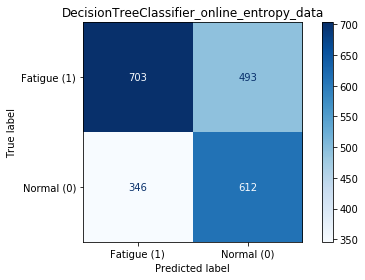

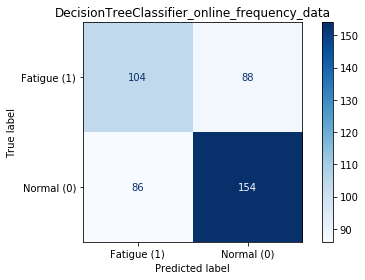

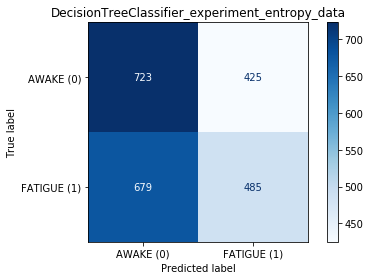

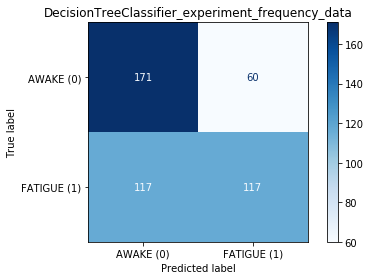

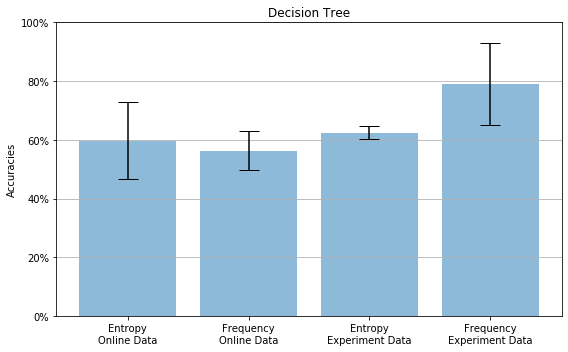

Saving figure Decision_Tree_metrics


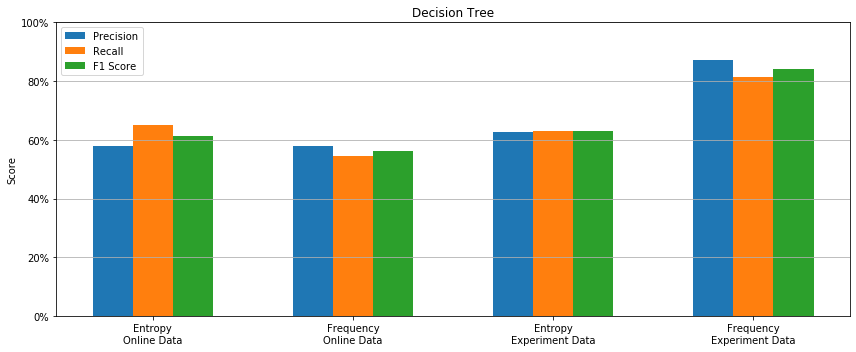

In [54]:
models = []
models.append(('entropy', DecisionTreeClassifier(criterion='gini', splitter='random')))
models.append(('frequency', DecisionTreeClassifier(criterion='entropy', splitter='random')))
models.append(('entropy_exp', DecisionTreeClassifier(criterion='gini', splitter='random')))
models.append(('frequency_exp', DecisionTreeClassifier(criterion='entropy', splitter='random')))

statisticsData = evaluteModelTypes(models, scoring_acc=True)
plot_accuaries(statisticsData, title="Decision Tree")
plot_metrcis(statisticsData, title="Decision Tree")

# Evaluate SVM

In [ ]:
models = []
models.append(('entropy', svm.SVC(kernel='poly', gamma='scale', degree=5)))
models.append(('frequency', svm.SVC(kernel='poly', gamma='scale', degree=5)))
models.append(('entropy_exp', svm.SVC(kernel='poly', gamma='scale', degree=5)))
models.append(('frequency_exp', svm.SVC(kernel='poly', gamma='scale', degree=5)))

evaluteModelTypes(models, scoring_acc=True)
plot_accuaries(statisticsData, title="Support Vector Machine")
plot_metrcis(statisticsData, title="Support Vector Machine")


######### Entropy - Online EEG Data #########
Model: SVC(degree=5, kernel='poly')
Calculating cross val scores...
Cross val scores (Accuracies):
 Fold 1: 0.5207006369426752
 Fold 2: 0.678343949044586
 Fold 3: 0.6369426751592356
 Fold 4: 0.8073248407643312
 Fold 5: 0.7340764331210191
 Fold 6: 0.9187898089171974
 Fold 7: 0.8535031847133758
 Fold 8: 0.8455414012738853
------------------
Mean: 0.7494028662420382
Std. Dev.: 0.13221338771398994

Caclulating cross val predictions...

Confusion Matrix
------------------------
    True Negative:   1541 - False Positive: 852
    False Negatives: 407 - True positive:  2224
----------------------
Precision: 0.7230169050715215 
Recall:    0.8453059673128088
F1 Score:  0.7793937270019274

######### Frequency - Online EEG Data #########
Model: SVC(degree=5, kernel='poly')
Calculating cross val scores...
Cross val scores (Accuracies):
 Fold 1: 0.3968253968253968
 Fold 2: 0.4523809523809524
 Fold 3: 0.5952380952380952
 Fold 4: 0.5158730158730159
 Fold

# Random Forest

In [29]:
models = []
models.append(('entropy', RandomForestClassifier(max_features='log2', n_estimators=500, criterion='entropy')))
models.append(('frequency', RandomForestClassifier(max_features='log2', n_estimators=1000, criterion='entropy')))
models.append(('entropy_exp', RandomForestClassifier(max_features='log2', n_estimators=500, criterion='entropy')))
models.append(('frequency_exp', RandomForestClassifier(max_features='log2', n_estimators=1000, criterion='gini')))

evaluteModelTypes(models, scoring_acc=True)


######### Entropy - Online EEG Data #########
Model: RandomForestClassifier(criterion='entropy', max_features='log2',
                       n_estimators=500)
Calculating cross val scores...


KeyboardInterrupt: 

# K-nearest neighbour (KNN)

In [ ]:
models = []
models.append(('entropy', KNeighborsClassifier(n_neighbors=5, weights='distance')))
models.append(('frequency', KNeighborsClassifier(n_neighbors=5, weights='distance')))
models.append(('entropy_exp', KNeighborsClassifier(n_neighbors=5, weights='distance')))
models.append(('frequency_exp', KNeighborsClassifier(n_neighbors=5, weights='distance')))

evaluteModelTypes(models, scoring_acc=True)

# Gradient Boost

In [ ]:
models = []
models.append(('entropy', GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000, loss='deviance')))
models.append(('frequency', GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000, loss='deviance')))
models.append(('entropy_exp', GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000, loss='deviance')))
models.append(('frequency_exp', GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000, loss='deviance')))

evaluteModelTypes(models, scoring_acc=True)

# Ada Boost

In [ ]:
models = []
models.append(('entropy', AdaBoostClassifier(learning_rate=1.2, n_estimators=1000)))
models.append(('frequency', AdaBoostClassifier(learning_rate=1.2, n_estimators=1000)))
models.append(('entropy_exp', AdaBoostClassifier(learning_rate=1.2, n_estimators=1000)))
models.append(('frequency_exp', AdaBoostClassifier(learning_rate=1.2, n_estimators=1000)))

evaluteModelTypes(models, scoring_acc=True)

# Multilayer Perceptron

In [ ]:
models = []
models.append(('entropy', MLPClassifier(shuffle=True, hidden_layer_sizes=(4, 100), solver='adam', activation='tanh', learning_rate='constant', learning_rate_init=0.001, alpha=0.0001))
models.append(('frequency', MLPClassifier(shuffle=True, hidden_layer_sizes=(2, 100), solver='adam', activation='relu', learning_rate='constant', learning_rate_init=0.001, alpha=0.0001)))
models.append(('entropy_exp', MLPClassifier(shuffle=True, hidden_layer_sizes=(2, 200), solver='adam', activation='relu', learning_rate='constant', learning_rate_init=0.001, alpha=0.0001)))
models.append(('frequency_exp', MLPClassifier(shuffle=True, hidden_layer_sizes=(4, 50), solver='adam', activation='tanh', learning_rate='constant', learning_rate_init=0.001, alpha=0.0001)))

evaluteModelTypes(models, scoring_acc=True)